# Notebook file to calculate the AM of eigenmodes of a sphere

## Import all libs

In [1]:
from src.dispersion import * 
from src.VSH import * 
from src.extra_special import * 
from src.fields import (
    E_,
    H_,
    E_cart_,
    H_cart_
)
from src.AM import *
from src.misc import *

import numpy as np
import scipy.constants as const
import scipy.special as sp
from scipy import integrate
from cxroots import Rectangle, AnnulusSector, Circle
import cxroots
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # for text effects 
plt.rcParams.update({'font.size': 18})

Z_0 = np.sqrt(const.mu_0 / const.epsilon_0)  # vacuum impedance

## Find eigen frequency

### Particle parameters

If particle **dielectric** then
$$
\varepsilon_{\text{in}} = \varepsilon_{\text{dielectric}}, \qquad \mu_{\text{in}} = \mu_{\text{dielectric}}
$$
If particle is **metallic** then
$$
\varepsilon_{\text{in}}(\omega) = \varepsilon_{\infty} - \frac{\omega_p^2}{\omega^2 + i \Gamma \omega}
$$
where parameters are taken for Gold from Novotny book p. 380: 
- $\varepsilon_\infty = 1$
- $\omega_p = 13.8 \cdot 10^{15} \text{ [1/s]}$
- $\Gamma = 1.075 \cdot 10^{14} \text{ [1/s]}$

In [246]:
particle_type = "dielectric"  # "dielectric" or "metallic"
eps_dielectric = 10 + 0.0j
mu_dielectric = 1.0 + 0.0j

n = 1  # m = -n, ..., n

a = 50*const.nano

mode_type = "TM"  # "TE" or "TM"

eps_out = 1
mu_out = 1

### Dispersion equations

In compact form we can write them as
\begin{equation}
	\text{dispersion eq. for TE:} \qquad \frac{\mu_\text{in}}{\mu_\text{out}} \left( 1 + n_{\text{out}} z \frac{h_n^{(1)\prime} (n_{\text{out}} z)}{h_n^{(1)} (n_{\text{out}} z)}  \right) = 1 + n_\text{in} z \frac{j_n^\prime(n_\text{in} z)}{j_n (n_\text{in} z)}
\end{equation}
\begin{equation}
	\text{dispersion eq. for TM:} \qquad \frac{\varepsilon_\text{in}}{\varepsilon_\text{out}} \left( 1 + n_{\text{out}} z \frac{h_n^{(1)\prime} (n_{\text{out}} z)}{h_n^{(1)} (n_{\text{out}} z)}  \right) = 1 + n_\text{in} z \frac{j_n^\prime(n_\text{in} z)}{j_n (n_\text{in} z)}
\end{equation}
Here $z=k_0 a = \frac{\omega}{c} a \in \mathbb{Z}$ is the dimensionless **frequency**, and $n_{\text{in}} = \sqrt{\varepsilon_{\text{in}} \mu_{\text{in}}}$, $n_{\text{out}} = \sqrt{\varepsilon_{\text{out}} \mu_{\text{out}}}$. Prime shows the derivative with respect to the argument.

Which can be rewritten in a more sutable form for the numeric computation for TE modes
\begin{equation}
    f_{\text{TE}}(z) =  z \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} n_{\text{out}} j_n h_n^\prime - n_{\text{in}} j_n^\prime h_n  \right)
    + h_n j_n \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 1\right) = 0
\end{equation}
\begin{equation}
\frac{d}{dz}f_{\text{TE}}(z) = 
j_n h_n^\prime n_{\text{out}} \left( 2 \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 1\right)
+ j_n^\prime h_n n_{\text{in}} \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 2\right)
+ z \left\{ j_n^\prime h_n^\prime n_{\text{out}} n_{\text{in}} \left( \frac{\mu_{\text{in}} }{\mu_{\text{out}}} - 1\right) 
+ \frac{\mu_{\text{in}} }{\mu_{\text{out}}} n_{\text{out}}^2 j_n h_n^{\prime \prime} - n_{\text{in}}^2 j_n^{\prime \prime} h_n \right\}
\end{equation}

and for TM
\begin{equation}
    f_{\text{TM}}(z) =  z \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} n_{\text{out}} j_n h_n^\prime - n_{\text{in}} j_n^\prime h_n  \right)
    + h_n j_n \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 1\right) = 0
\end{equation}
\begin{equation}
\frac{d}{dz}f_{\text{TM}}(z) = 
j_n h_n^\prime n_{\text{out}} \left( 2 \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 1\right)
+ j_n^\prime h_n n_{\text{in}} \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 2\right)
+ z \left\{ j_n^\prime h_n^\prime n_{\text{out}} n_{\text{in}} \left( \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} - 1\right) 
+ \frac{\varepsilon_{\text{in}} }{\varepsilon_{\text{out}}} n_{\text{out}}^2 j_n h_n^{\prime \prime} - n_{\text{in}}^2 j_n^{\prime \prime} h_n \right\}
\end{equation}

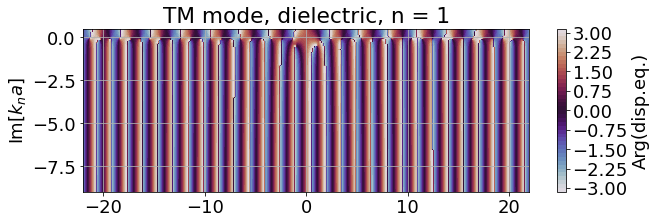

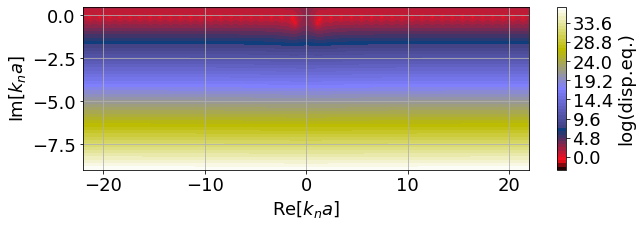

In [247]:
N = 300

z_re = np.linspace(-22, 22, num=N)
z_im = np.linspace(-9, 0.5, num=N)

X, Y = np.meshgrid(z_re, z_im, sparse=True)

if mode_type == "TE":
    foo_disp_nodiv = fTE
    foo_disp_nodiv_p = fTEp
elif mode_type == "TM":
    foo_disp_nodiv = fTM
    foo_disp_nodiv_p = fTMp

weightOrder = n
Z = foo_disp_nodiv(n, X + 1j*Y, a, eps_out, mu_out, particle_type, eps_dielectric, mu_dielectric, weightOrder=weightOrder)

ARG_Z = np.angle(Z)

#potolok = 15
#Z[np.log(np.abs(Z)) > potolok] = np.nan # np.exp(potolok)

plt.figure(figsize=(10, 3.))
plt.contourf(z_re, z_im, ARG_Z, levels=50, cmap="twilight")
plt.colorbar(label="Arg(disp.eq.)")
plt.title(mode_type + " mode, " + particle_type + ", n = %d" % n)
#plt.xlabel("$\operatorname{Re}[k_n a]$")
plt.ylabel("$\operatorname{Im}[k_n a]$")
#plt.yscale("log")
plt.grid()
#plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.))
plt.contourf(z_re, z_im, np.log(np.abs(Z)), levels=50, cmap="gist_stern")
plt.colorbar(label="log(disp.eq.)")
#plt.title(mode_type + " mode, " + particle_type + ", n = %d" % n)
plt.xlabel("$\operatorname{Re}[k_n a]$")
plt.ylabel("$\operatorname{Im}[k_n a]$")
#plt.yscale("log")
plt.grid()
#plt.tight_layout()
plt.show()

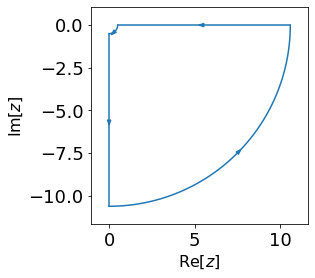

In [248]:
#sector = AnnulusSector(
#    center=-1e-2 * 0 + 1e-1j, radii=(1, 6), phiRange=(-np.pi, 0)
#)
#sector = Circle(0, 7)
#sector = Rectangle(xRange=(-2.5, 9), yRange=(-3, 1))
#sector.show()

ABS_Z_MAX = 10.6

sector = AnnulusSector(
    center=-1e-2 - 1e-2j, radii=(0.5, ABS_Z_MAX), phiRange=(-np.pi/2, 0)
)
sector.show()

$$
\ 
$$

/home/ivan/.local/lib/python3.10/site-packages/cxroots/RootFinder.py:314: UserWarning: The area of the interior of this contour with is smaller than newtonStepTol!  Try increasing rootTolThe point z = -9.427149 + -0.104796i has been recorded as a root of multiplicity 1.The error |f(z)| = 8.978787909386907e-15
  warnings.warn("The area of the interior of this contour with is smaller than newtonStepTol!  Try increasing rootTol" \
/home/ivan/.local/lib/python3.10/site-packages/cxroots/RootFinder.py:314: UserWarning: The area of the interior of this contour with is smaller than newtonStepTol!  Try increasing rootTolThe point z = -8.432397 + -0.105109i has been recorded as a root of multiplicity 1.The error |f(z)| = 5.315789943881364e-15
  warnings.warn("The area of the interior of this contour with is smaller than newtonStepTol!  Try increasing rootTol" \
/home/ivan/.local/lib/python3.10/site-packages/cxroots/RootFinder.py:314: UserWarning: The area of the interior of this contour with is 

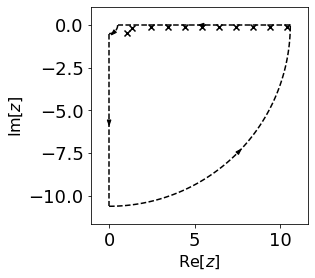

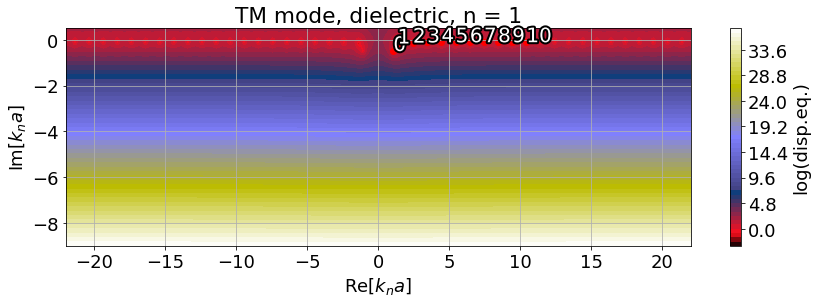

In [249]:
#sector = AnnulusSector(
#    center=0.0, radii=(0.5, 25), phiRange=(-np.pi*0.2 - np.pi, np.pi*0.2)
#)
#sector = Rectangle(
#    xRange=(-5, 5), 
#    yRange=(1, -5)
#)
#sector = Circle(0, 5)
# sector.show()

# Define f(z)
f  = lambda z: foo_disp_nodiv(
    n, z, a, eps_out, mu_out, particle_type, eps_dielectric, mu_dielectric, weightOrder=weightOrder)      

# Define f'(z)
if particle_type == "dielectric":
    df = lambda z: foo_disp_nodiv_p(
        n, z, a, eps_out, mu_out, particle_type, eps_dielectric, mu_dielectric, weightOrder=weightOrder) 
else:
    dz = 1e-8
    df = lambda z: (f(z+dz) - f(z-dz)) / (2*dz)

# roots have symmetry Re(z) -> -Re(z)
def RootSymmetry(z):
    # https://rparini.github.io/cxroots/guesses.html?highlight=rootsymmetry
    return [-np.real(z) + 1j*np.imag(z)]
    
# https://github.com/rparini/cxroots/blob/037247fc47b29781b9cc66857a8395283e8ecc86/cxroots/RootFinder.py#L33
roots = sector.roots(f, df, integerTol=0.1, rootErrTol=1e-5, guessRootSymmetry=RootSymmetry)
roots.show()

# remember the roots
zr = np.array(roots.roots)
zr = np.sort(zr)

# plot nicely
fig, ax = plt.subplots(figsize=(14, 4))
im = ax.contourf(z_re, z_im, np.log(np.abs(Z)), levels=50, cmap="gist_stern")
fig.colorbar(im, label="log(disp.eq.)")
ax.scatter(np.real(zr), np.imag(zr), c="r")

for i in range(len(zr)):
    plt.annotate(
        str(i), (np.real(zr[i]), np.imag(zr[i])), 
        c="w", size=20, path_effects=[pe.withStroke(linewidth=4, foreground="black")])

# physical area
#ax.add_patch(Rectangle([0, 0], np.max(z_re), np.min(z_im), alpha=0.05, color="blue")) 
#plt.annotate("Physical solutions", (np.max(z_re)/3.5, np.min(z_im)/1.5), c="w")
# unphysical area
#ax.add_patch(Rectangle([np.min(z_re), 0], np.max(z_re)-np.min(z_re), np.max(z_im), alpha=0.4, color="white")) 
#ax.add_patch(Rectangle([0, 0], np.min(z_re), np.min(z_im), alpha=0.4, color="white")) 



plt.title(mode_type + " mode, " + particle_type + ", n = %d" % n)
plt.xlabel("$\operatorname{Re}[k_n a]$")
plt.ylabel("$\operatorname{Im}[k_n a]$")
plt.grid()
plt.show()

### Setting up the eigen frequency of choice

Choose the numer from the plot above.
$$
\omega  = \frac{z c}{a}
$$
since $z = k_0 a = \frac{\omega}{c} a$.

In [256]:
omega = zr[1]/a * const.speed_of_light
k0 = omega / const.speed_of_light

omega_array = zr/a * const.speed_of_light
k0_array = omega_array / const.speed_of_light

ic(omega);

ic| omega: (8137296575907747-965201009799563j)


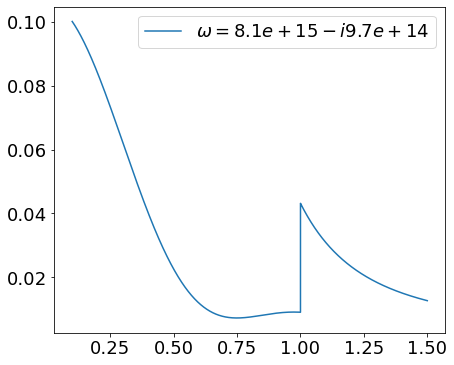

In [257]:
rr = np.linspace(0.1*a, stop=1.5*a, num=30000)

theta = 2.0
phi = 2.0

m = 1

plt.figure(figsize=(7, 6))
#for (i,omega) in enumerate(omega_array):
#    if np.real(omega) > 0:
EE = np.linalg.norm(E_VSH(m, n, rr, theta, phi, mode_type, a, omega, particle_type,
   eps_out, mu_out, eps_dielectric, mu_dielectric), axis=0)**2
plt.plot(rr/a, EE, label="$\omega = %.1e - i%.1e$" % (np.real(omega), -np.imag(omega)))

plt.legend()
#plt.ylim(0, 2)
plt.show()

In [258]:
"""
rr = np.linspace(0.1*a, stop=1.5*a, num=300)

theta = 2.0
phi = 2.0

m = 1


for (i,omega) in enumerate(omega_array):
    if np.real(omega) > 0:
        plt.figure(figsize=(3, 3))
        EE = np.linalg.norm(E_VSH(m, n, rr, theta, phi, mode_type, a, omega, particle_type,
           eps_out, mu_out, eps_dielectric, mu_dielectric), axis=0)**2
        plt.plot(rr/a, EE, lw=3, c="C3", label="%d" % i)
        plt.legend()
        #plt.ylabel("$|\mathbf{E}|^2$")
        plt.xlabel("$r/a$")
        #plt.ylim(0, 0.75)
        plt.show()
"""

'\nrr = np.linspace(0.1*a, stop=1.5*a, num=300)\n\ntheta = 2.0\nphi = 2.0\n\nm = 1\n\n\nfor (i,omega) in enumerate(omega_array):\n    if np.real(omega) > 0:\n        plt.figure(figsize=(3, 3))\n        EE = np.linalg.norm(E_VSH(m, n, rr, theta, phi, mode_type, a, omega, particle_type,\n           eps_out, mu_out, eps_dielectric, mu_dielectric), axis=0)**2\n        plt.plot(rr/a, EE, lw=3, c="C3", label="%d" % i)\n        plt.legend()\n        #plt.ylabel("$|\\mathbf{E}|^2$")\n        plt.xlabel("$r/a$")\n        #plt.ylim(0, 0.75)\n        plt.show()\n'

## AM calculations

From here $n$ is fixed!

In [259]:
n

1

### Jz

In [260]:
N = 100
boxSize = 2*a

m = 1

xx = np.linspace(-boxSize, stop=boxSize, num=N)
y = 0
zz = np.linspace(-boxSize, stop=boxSize, num=N)


X, Z = np.meshgrid(xx, zz, sparse=False, indexing='ij')

R, THETA, PHI = cart2sph(X, y, Z)

sz = sz_(
    m, n, 
    R, THETA, PHI, 
    mode_type, a, omega, particle_type, 
    eps_out, mu_out, eps_dielectric, mu_dielectric
)
lz = lz_(
    m, n, 
    R, THETA, PHI, 
    mode_type, a, omega, particle_type, 
    eps_out, mu_out, eps_dielectric, mu_dielectric
)
jz = jz_(
    m, n, 
    R, THETA, PHI, 
    mode_type, a, omega, particle_type, 
    eps_out, mu_out, eps_dielectric, mu_dielectric
)
jz_kin = jz_kinetic_(
    m, n, 
    R, THETA, PHI, 
    mode_type, a, omega, particle_type, 
    eps_out, mu_out, eps_dielectric, mu_dielectric
)

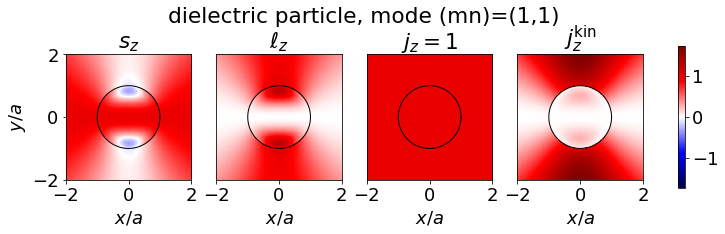

In [261]:
FF = [sz, lz, jz, jz_kin]
names = ['$s_z$', '$\ell_z$', '$j_z = %d$'%(m), '$j^{\mathrm{kin}}_z$']
vmax = np.max(np.abs(FF))
vmin = - vmax
extent = (xx[0]/a, xx[-1]/a, zz[0]/a, zz[-1]/a)

phi_circ = np.linspace(0, stop=2*np.pi, num=100)
x_circ, y_circ = np.cos(phi_circ), np.sin(phi_circ)

fig, axes = plt.subplots(figsize=(len(FF)*2.5, 3), ncols=len(FF), constrained_layout=True)
fig.suptitle('{} particle, mode (mn)=({},{})'.format(particle_type, m, n))
for i, ax in enumerate(axes):
    im = ax.plot(x_circ, y_circ, lw=1, c='k')
    im = ax.imshow(FF[i], vmin=vmin, vmax=vmax, origin='lower', cmap='seismic', extent=extent)
    ax.set_title(names[i])
    ax.set_xlabel('$x/a$')
    if i == 0:
        ax.set_ylabel('$y/a$')
    if i > 0:
        #ax.set_ylabel('$y/a$')
        ax.set_yticks([])
    

cbar = fig.colorbar(im, ax=axes)
#cbar.set_label('AM per photon', rotation=270, fontsize=13)

plt.show()

### Square of total momenta

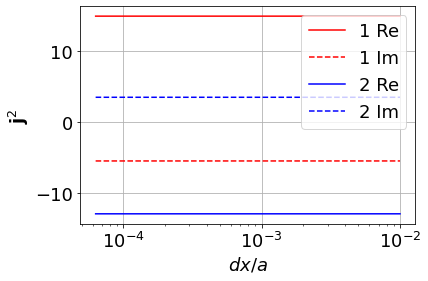

ic| (n+1)*(n+2): 20
    n*(n+1): 12
    m**2: 1
    (m+1)**2: 4
    np.real(j2canon)[0]: 14.986194787219512
    np.imag(j2canon)[0]: -5.505515618307019
    np.real(j2canon2)[0]: -12.986193140923866
    np.imag(j2canon2)[0]: 3.5055144621855914


In [10]:
a = 1
omega = 2*const.speed_of_light

n, m = 3, 1
#m = 1

mode_type = "TE"
particle_type = "dielectric"

r = 2.1*a
theta = 1.2
phi = 1.0

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta) 

epshSpace = 10.0**np.linspace(-4.2, stop=-2, num=7)
j2canon = np.zeros(np.size(epshSpace)) + 0.0j
j2canon2 = np.zeros(np.size(epshSpace)) + 0.0j

part = "electric"


for (i, epsh) in enumerate(epshSpace):
    J2canon = J2_canonical_(
        m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part, epsh=epsh
    )
    J2canon2 = J2_canonical2_(
        m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part, epsh=epsh
    )
    W = W_(
        m, n, r, theta, phi, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part
    )
    j2canon[i] = J2canon / (W/np.abs(omega))
    j2canon2[i] = J2canon2 / (W/np.abs(omega))


plt.plot(epshSpace, np.real(j2canon), c="red", label="1 Re")
plt.plot(epshSpace, np.imag(j2canon), c="red", ls="--", label="1 Im")

plt.plot(epshSpace, np.real(j2canon2), c="blue", label="2 Re")
plt.plot(epshSpace, np.imag(j2canon2), c="blue", ls="--", label="2 Im")

plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.ylabel("$\mathbf{j}^2$")
plt.xlabel("$dx/a$")
plt.grid()
#plt.ylim(0, 12)
plt.show()


ic(
    (n+1)*(n+2),
    n*(n+1),
    m**2,
    (m+1)**2,
    np.real(j2canon)[0], 
    np.imag(j2canon)[0],
    np.real(j2canon2)[0], 
    np.imag(j2canon2)[0]
);

In [29]:
ic(m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric);

ic| m: 3
    n: 3
    x: 1.057524021345384
    y: 1.6469960798514167
    z: 0.7609512844010147
    mode_type: 'TE'
    a: 1
    omega: 2
    particle_type: 'dielectric'
    eps_out: 1
    mu_out: 1
    eps_dielectric: (10+0j)
    mu_dielectric: (1+0j)
